# Auto ARIMA model

1. Import required libaries

In [22]:
!pip install pmdarima
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


2. Import dataset

In [23]:
final_df = pd.read_csv('final_dt.csv')
final_df

,REF_DATE,Close,SMA_10,SMA_50,SMA_100,SMA_200,close_trend,cpi,gross_income,housing,prime_rate
0,1981-01-02,2290.399902,2266.609985,2284.252002,2284.515005,2128.722005,2262.289576,46.9,84592.244444,38.216129,18.25
1,1981-01-05,2307.100098,2273.469995,2283.106006,2285.332007,2130.521005,2259.309367,46.9,84754.977778,38.264516,18.25
2,1981-01-06,2319.399902,2280.839990,2282.340005,2286.058005,2132.794005,2256.409365,46.9,84809.222222,38.280645,18.25
3,1981-01-07,2265.399902,2280.929980,2281.186001,2286.319004,2134.697004,2253.921865,46.9,84863.466667,38.296774,18.25
4,1981-01-08,2248.300049,2277.549976,2279.768003,2286.387004,2136.318504,2251.417699,46.9,84917.711111,38.312903,18.25
...,...,...,...,...,...,...,...,...,...,...,...
10293,2021-12-23,21218.900390,20828.799805,21162.001953,20814.651016,20204.845010,21023.557251,144.0,642069.684783,121.580645,2.45
10294,2021-12-24,21229.699220,20862.709766,21168.033945,20823.651016,20216.770508,21017.748922,144.0,641776.608696,121.616129,2.45
10295,2021-12-29,21344.699220,20922.329688,21175.219922,20833.343008,20229.237500,21015.745789,144.0,640311.228261,121.793548,2.45
10296,2021-12-30,21294.599610,20986.929688,21179.371914,20841.535000,20240.936494,21010.060364,144.0,640018.152174,121.829032,2.45


3. Convert REF_DATE to datetime format to be used for the ARIMA model

In [24]:
final_df['REF_DATE']=pd.to_datetime(final_df['REF_DATE'])

4. Set index to be REF_DATE 

In [25]:
el_df=final_df.set_index('REF_DATE')

In [26]:
#drop close_trend as Auto ARIMA will has a seasonality component
el_df=el_df.drop(['close_trend'], axis=1)

5. Initialize the Auto ARIMA function. EL_DF is passed into the model with the Close column as the column to be predicted. 

  Auto ARIMA will search for the optimal value for p, d, and q. 

  p - the number of time lags

  d - the order of first-differencing

  q - the order of moving average

  seasonal - default is True

In [27]:
model = pm.auto_arima(el_df['Close'], 
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=123584.167, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=123571.787, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=123572.219, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=123585.814, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=123571.837, Time=1.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=123573.017, Time=1.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=123572.716, Time=4.73 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=123573.716, Time=0.25 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 9.383 seconds


6. Split the data into train and test. Here, only keeping the test date to 21 days in December 2021.

In [28]:
train=el_df[(el_df.index.get_level_values(0) <= "2021-11-30")]

In [29]:
test=el_df[(el_df.index.get_level_values(0) > "2021-11-30")]

7. Passing the train data into the ARIMA model.

In [30]:
model.fit(train['Close'])

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

8. Based on the previously trained model, make prediction for 21 periods.

In [31]:
forecast=model.predict(n_periods=21, return_conf_int=True)

10. Storing the forecasted Close price into a new dataframe column named 'Prediction'

In [32]:
forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])

11. Graph the actual Close price and the Predicted Price for the test period.

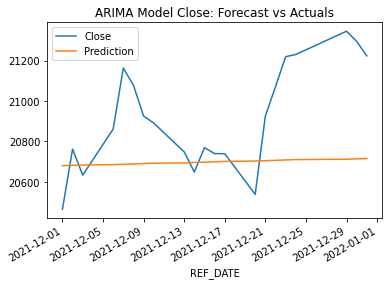

In [33]:
pd.concat([test['Close'],forecast_df],axis=1).plot(legend=True,title='ARIMA Model Close: Forecast vs Actuals')

12. Final Evaluation of the Model

MAPE: Mean Absolute Percentage Error

MAE: Mean Absolute Error

MPE: Mean Percenage Error

RMSE: Root Mean Square Error

CORR: Correlation Coefficent

Coefficient, r

Strength of Association	Positive	Negative

Small	                 .1 to .3 or	-0.1 to -0.3

Medium	               .3 to .5 or	-0.3 to -0.5

Large	                 .5 to 1.0 or	-0.5 to -1.0

In [34]:
#Evaluate Forecast

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr})

print('Forecast Accuracy of: Close')
accuracy_prod = forecast_accuracy(forecast_df['Prediction'].values, test['Close'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))



Forecast Accuracy of: Close
mape :  0.0126
mae :  265.2884
mpe :  -0.0104
rmse :  331.3257
corr :  0.6146
